In [1]:
import os, sys, copy, time
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
import multiprocessing
from functools import partial
import cv2
import skimage.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
import torchaudio.transforms as AT
from torch.utils.data import  Dataset, TensorDataset, DataLoader
from efficientnet_pytorch import EfficientNet
from typing import Type, Any, Callable, Union, List, Optional
from IPython.display import HTML
from IPython import display
import librosa.display
from tqdm import tqdm
from sklearn.model_selection import train_test_split

random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

print(torch.__version__)

1.10.2+cu113


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if (device.type == 'cuda') and (torch.cuda.device_count() >1):
    print("Multi GPU activate")
device

Multi GPU activate


device(type='cuda')

### Parameters

In [3]:
batch_size = 2048
epochs = 300
print_every = 1
# window = 20
# step_size = 10
# window_type = 'avg'
# emb_size = 512
# d_model = 512
# max_len = 2000
patience = 1000

dataset_list = ["DS_testOK80NG20_type1"]
model_save_dir = "./Trained_models-l6-512"
existing_model_path = os.path.join(model_save_dir, 'params-1001.pk')

In [4]:
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print('"%s" has been created.'%(model_save_dir))
else:
    print("The folder already exists.")    
   

"./Trained_models-l6-512" has been created.


### Get data

In [5]:
x_train = []
y_train = []
x_test = []
y_test = []
for ds in dataset_list:
    ds_path = os.path.join("../Dataset", ds)    
    x_train.append( np.load(os.path.join(ds_path, 'x_train_OK.npy')) )
    y_train.append( np.load(os.path.join(ds_path, 'y_train_OK.npy')) )
    x_train.append( np.load(os.path.join(ds_path, 'x_train_NG.npy')) )
    y_train.append( np.load(os.path.join(ds_path, 'y_train_NG.npy')) )
    x_test.append( np.load(os.path.join(ds_path, 'x_test_OK.npy')) )
    y_test.append( np.load(os.path.join(ds_path, 'y_test_OK.npy')) )
    x_test.append( np.load(os.path.join(ds_path, 'x_test_NG.npy')) )
    y_test.append( np.load(os.path.join(ds_path, 'y_test_NG.npy')) )

x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1405, 47) (1405, 2) (100, 47) (100, 2)


### Split dataset

In [6]:
start_time = time.time()

x_val = copy.deepcopy(x_test)
y_val = copy.deepcopy(y_test)

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.00019884109497070312 seconds ---


In [7]:
x_train = torch.tensor(x_train).type(torch.float)
y_train = torch.tensor(y_train).type(torch.float )
x_val = torch.tensor(x_val).type(torch.float)
y_val = torch.tensor(y_val).type(torch.float )
x_test = torch.tensor(x_test).type(torch.float)
y_test = torch.tensor(y_test).type(torch.float )

y_train = y_train.view(-1, 2)
y_val = y_val.view(-1, 2)
y_test = y_test.view(-1, 2)

print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([1405, 47]) torch.Size([100, 47]) torch.Size([100, 47])
torch.Size([1405, 2]) torch.Size([100, 2]) torch.Size([100, 2])


In [8]:
val_ds = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
print(val_ds[0][0].shape, val_ds[0][1].shape)

torch.Size([47]) torch.Size([2])


In [9]:
class DefectInspector0(torch.nn.Module):
    def __init__(self,                            
                 in_size: int = 47,
                 out_size: int = 2,                                 
                 dropout: float = 0.1
                ):
        super(DefectInspector0, self).__init__()

        layer_size = 512
        self.name = 'DefectInspector0'        
        self.out_size = out_size
        
        self.linear1 = torch.nn.Linear(in_size, layer_size)
        self.bn1 = torch.nn.BatchNorm1d(layer_size)
        self.relu1 = torch.nn.ReLU(inplace=False)
        self.dropout1 = torch.nn.Dropout(dropout)
        
        self.linear2 = torch.nn.Linear(layer_size, layer_size)
        self.bn2 = torch.nn.BatchNorm1d(layer_size)
        self.relu2 = torch.nn.ReLU(inplace=False)
        self.dropout2 = torch.nn.Dropout(dropout)
        
        self.linear3 = torch.nn.Linear(layer_size, layer_size)
        self.bn3 = torch.nn.BatchNorm1d(layer_size)
        self.relu3 = torch.nn.ReLU(inplace=False)
        self.dropout3 = torch.nn.Dropout(dropout)
        
        self.linear4 = torch.nn.Linear(layer_size, layer_size)
        self.bn4 = torch.nn.BatchNorm1d(layer_size)
        self.relu4 = torch.nn.ReLU(inplace=False)
        self.dropout4 = torch.nn.Dropout(dropout)
        
        self.linear5 = torch.nn.Linear(layer_size, layer_size)
        self.bn5 = torch.nn.BatchNorm1d(layer_size)
        self.relu5 = torch.nn.ReLU(inplace=False)
        self.dropout5 = torch.nn.Dropout(dropout)
        
        self.linear6 = torch.nn.Linear(layer_size, layer_size)
        self.bn6 = torch.nn.BatchNorm1d(layer_size)
        self.relu6 = torch.nn.ReLU(inplace=False)
        self.dropout6 = torch.nn.Dropout(dropout)
        
        self.final_linear = torch.nn.Linear(layer_size, out_size, bias=True)  

    def forward(self, src: torch.Tensor): # src : (B, S, F)   
        
        out = self.linear1(src)       # (B, S, emb_size)      
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.linear2(out)       # (B, S, emb_size)      
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.linear3(out)       # (B, S, emb_size)      
        out = self.bn3(out)
        out = F.relu(out)
        
        out = self.linear4(out)       # (B, S, emb_size)      
        out = self.bn4(out)
        out = F.relu(out)
        
        out = self.linear5(out)       # (B, S, emb_size)      
        out = self.bn5(out)
        out = F.relu(out)
        
        out = self.linear6(out)       # (B, S, emb_size)      
        out = self.bn6(out)
        out = F.relu(out)
        
        return self.final_linear(out)       # (B, S, emb_size)      

In [10]:
model = DefectInspector0(in_size=x_val.shape[1],
                         out_size=y_val.shape[1])

checkpoint = None

load_model = True
if load_model:
    try:
        #model = torch.load(os.path.join(model_save_dir, 'saved_model-10.pk'))
        checkpoint = torch.load(existing_model_path) 
        model.load_state_dict(checkpoint['model_state_dict'])
        print("The model has been loaded.")
         
    except:
        print("There are no models.")
        load_model = False



if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=[0,1])
model.to(device)

print("-"*50)        

There are no models.
--------------------------------------------------


100 0.0007781103656844778
200 0.002277281500555009
300 1.3288651294691734e-06


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


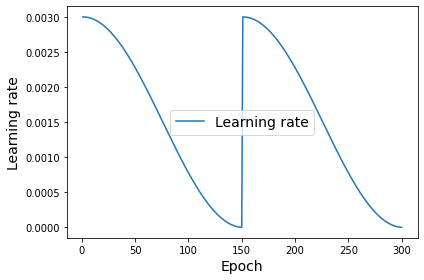

In [11]:
import transformers

#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, betas=(0.9, 0.98), eps=1e-09)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)                    
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.000001, last_epoch=-1, verbose=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(epochs/2), T_mult=1, eta_min=0.000001, last_epoch=-1, verbose=False)
# scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=400, T_mult=1, eta_max=0.0001, T_up=50, gamma=1.0)
# optimizer = transformers.AdamW(model.parameters(), lr=0.005)
# scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=epochs, num_cycles=1, last_epoch=-1)

epoch_li = []
lr_li = []
last_epoch = 10
for epoch in range(1, last_epoch+1):
    lr = scheduler.get_lr()[0]    
    epoch_li.append(epoch)
    lr_li.append(lr)
    scheduler.step(epoch)        
#     print(epoch, lr)
for epoch in range(last_epoch+1, epochs+1):
    
    lr = scheduler.get_lr()[0]        
    epoch_li.append(epoch)
    lr_li.append(lr)

    scheduler.step(epoch)        
    if epoch%100==0 :
        print(epoch, lr)

# plt.title("Learning rate", fontsize=18) 
plt.plot( epoch_li, lr_li, label='Learning rate')
plt.xlabel( "Epoch", fontsize=14)
plt.ylabel( "Learning rate", fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig( os.path.join(model_save_dir, 'learning-rate.jpg') , dpi=199) 
plt.show()

In [12]:
def evaluate(model, data_loader): 
    accuracy_sum = 0
    loss_sum = 0    
    criterion = nn.BCELoss()# nn.CrossEntropyLoss() #nn.MSELoss()
    nIter = 0    
    with torch.no_grad(): 
        model.eval()   
        for i, data in enumerate(data_loader):
            output = model(data[0].to(device))
            probs = F.softmax(output, dim=1)            
            out_max, out_indices = torch.max(probs, dim=1)            
            target_max, target_indices = torch.max(data[1].to(device), dim=1)
            accuracy = (out_indices==target_indices).sum()/data[0].size(0)
            accuracy_sum += accuracy            
            loss = criterion(F.softmax(output, dim=1), data[1].to(device))
            loss_sum += loss   
            nIter+=1            
    model.train()
    return loss_sum.item()/nIter, accuracy_sum.item()/nIter

In [13]:
def train(train_loader, val_loader, optimizer, scheduler ):
    print("Learning start...")
    train_start = time.time()
        
    criterion = nn.BCELoss()#nn.CrossEntropyLoss()#nn.MSELoss()
        
    epoch_start = 1    
    train_loss_li = []
    val_loss_li = []    
    train_acc_li = []
    val_acc_li = []    
    time_taken = 0.0    
    best_train_accs = np.zeros(10)
    best_val_accs = np.zeros(10)
            
    if load_model:
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch']+1             
        train_loss_li = checkpoint['train_loss_li']
        val_loss_li = checkpoint['val_loss_li']
        train_acc_li = checkpoint['train_acc_li']
        val_acc_li = checkpoint['val_acc_li']
        best_train_accs = np.sort(np.array(train_acc_li))[::-1][:10]
        best_val_accs = np.sort(np.array(val_acc_li))[::-1][:10]
        time_taken = checkpoint['time']
        print('start epoch : %d'%(epoch_start))
        print('best train loss : %f'%(best_train_accs.min()))
        print('best val loss : %f'%(best_val_accs.min()))
        print("="*50)
    
    for epoch in range(1, epoch_start):
        lr = scheduler.get_lr()[0]            
        scheduler.step(epoch)   

    patience_iter = 0
    #sigmoid = nn.Sigmoid()
    for epoch in range(epoch_start, epochs+1):
        epoch_start = time.time()
        print("Epoch %d start.-------------------------------------------"%(epoch))
        
        #best_model_weights = copy.deepcopy(model.state_dict())
        #best_accuracy = 0.0        
        
        nIter = 0
        train_loss = 0
        train_acc = 0
        model.train()         
        
        for i, (inputs, targets) in enumerate(tqdm(train_loader)):
            # print(inputs.size())
            # print(targets.type())

            optimizer.zero_grad()                        
            output = model(inputs.to(device))   
            loss = criterion(F.softmax(output, dim=1), targets.to(device))
            
            probs = F.softmax(output, dim=1)
            out_max, out_indices = torch.max(probs, dim=1)            
            target_max, target_indices = torch.max(targets.to(device), dim=1)
            accuracy = (out_indices==target_indices).sum()/inputs.size(0)
            
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()        
            train_loss += loss
            train_acc += accuracy
            nIter+=1

        train_loss = train_loss.item()/nIter        
        train_acc = train_acc.item()/nIter
        val_loss, val_acc = evaluate(model, val_loader)        
                
        train_loss_li.append(train_loss)            
        val_loss_li.append(val_loss)
        train_acc_li.append(train_acc)            
        val_acc_li.append(val_acc)
        
#         train_best1 = best_train_losses.min()
#         train_best10 = best_train_losses.max()
        val_best1 = best_val_accs.max()
        val_best10 = best_val_accs.min()
        print(val_best1, val_best10)
        
#         if ( epoch % print_every==0  ) :    
        if val_acc>=val_best10 or (epoch==epochs) or (epoch%10==0): 
            model_to_be_saved = model
            if torch.cuda.device_count() > 1:     
                model_to_be_saved = model.module  

            save_param_path = os.path.join(model_save_dir, "params-" + str(epoch) + '.pk')                  
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': model_to_be_saved.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),                        
                    'train_loss_li': train_loss_li, 
                    'val_loss_li' : val_loss_li,
                    'train_acc_li': train_acc_li, 
                    'val_acc_li' : val_acc_li,
                    'time' : (time_taken + time.time() - train_start)
                    }, save_param_path)
            #save_model_path = os.path.join(model_save_dir, "model-" + str(epoch) + '.pk')  
            #torch.save(model_to_be_saved, save_model_path)                                          
            
            if (val_acc >= val_best10) :
                best_val_accs[np.argmin(best_val_accs)] = val_acc

            if (val_acc >= val_best1) :
                patience_iter=0
                print( "The best val loss improved from %f to %f"%(val_best1, val_acc))
            else:
                patience_iter+=1

        else:
            patience_iter+=1
            print("val_loss did not improve from %f"%(best_val_accs.max()))
        
        if patience_iter>=patience:
            break
        
        print("=> mse : %f | val_loss : %f | train_acc : %.2f | val_acc : %.2f | lr : %e -  %fs"%( train_loss, val_loss, train_acc, val_acc, scheduler.get_lr()[0], (time.time() - epoch_start)))
        print("=> Time spent : %fs"%( time_taken + time.time() - train_start ) )
        print("-"*50)
        
        # Update learning rate
        scheduler.step(epoch)
        
        if (epoch % 10==0):
            display.clear_output(wait=True)

In [14]:
train_ds = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
print(train_ds[0][0].shape, train_ds[0][1].shape)

torch.Size([47]) torch.Size([2])


In [15]:
start_time = time.time()
train(train_loader, val_loader, optimizer, scheduler)
print("--- %s seconds ---"%(time.time()-start_time))
print("Training complete")

--- 480.52864837646484 seconds ---
Training complete
